In [1]:
# Fix sys path to root directory so locally defined packages can be found
import sys
sys.path.append('C:\\Users\\2270577A\\PycharmProjects\\PhD_LCA_TEA')


In [2]:
import math

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from configs import gaussian, triangular
from functions.MonteCarloAnalysis import make_dist


# Biochar carbon content based on feedstock type (based on IPCC data)

In [3]:
# Get data
biochar_carbon_data = {"animal manure": {"mean": 0.09, "95%": 0.53},
                       "wood": {"mean": 0.52, "95%": 0.52},
                       "herbaceous biomass": {"mean": 0.28, "95%": 0.50},
                       "rice husk and rice straw": {"mean": 0.13, "95%": 0.50},
                       "nut shells, pits, and stones": {"mean": 0.40, "95%": 0.52},
                       "biosolids (paper sludge, sewage sludge)": {"mean": 0.07, "95%": 0.50}
                       }

source = {"Title": "Method for estimating the change in mineral soil organic carbon stocks from biochar amendments: "
                   "basis for future methodological development",
          "Publication": "2019 Refinement to the 2006 IPCC Guidelines for National Greenhouse Gas Inventories",
          "URL": "https://www.ipcc-nggip.iges.or.jp/public/2019rf/pdf/4_Volume4/19R_V4_Ch02_Ap4_Biochar.pdf"}

# Create dataframe and add rows which are to be calculated
biochar_carbon_df = pd.DataFrame(biochar_carbon_data)
added_rows_df = pd.DataFrame(columns=biochar_carbon_df.columns, index=["lower", "upper", "std"])
biochar_carbon_df = pd.concat([biochar_carbon_df, added_rows_df])
biochar_carbon_df

,animal manure,wood,herbaceous biomass,rice husk and rice straw,"nut shells, pits, and stones","biosolids (paper sludge, sewage sludge)"
mean,0.09,0.52,0.28,0.13,0.40,0.07
95%,0.53,0.52,0.50,0.50,0.52,0.50
lower,NaN,NaN,NaN,NaN,NaN,NaN
upper,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Calculate upper and lower 95% confidence limit and standard deviation
for label in biochar_carbon_df.columns:
    # extract data
    mean = biochar_carbon_df.loc["mean"][label]
    confidence_interval_95 = biochar_carbon_df.loc["95%"][label]

    # do calculations
    lower = mean - (mean * confidence_interval_95)  # calculate lower confidence interval
    upper = mean + (mean * confidence_interval_95)  # calculate upper confidence interval
    std = math.sqrt(1) * (upper - lower) / 3.92  # calculate standard deviation from confidence intervals

    # store calculated parameters
    biochar_carbon_df[label]["lower"] = lower
    biochar_carbon_df[label]["upper"] = upper
    biochar_carbon_df[label]["std"] = std
biochar_carbon_df

,animal manure,wood,herbaceous biomass,rice husk and rice straw,"nut shells, pits, and stones","biosolids (paper sludge, sewage sludge)"
mean,0.090000,0.520000,0.280000,0.130000,0.400000,0.070000
95%,0.530000,0.520000,0.500000,0.500000,0.520000,0.500000
lower,0.042300,0.249600,0.140000,0.065000,0.192000,0.035000
upper,0.137700,0.790400,0.420000,0.195000,0.608000,0.105000
std,0.024337,0.137959,0.071429,0.033163,0.106122,0.017857


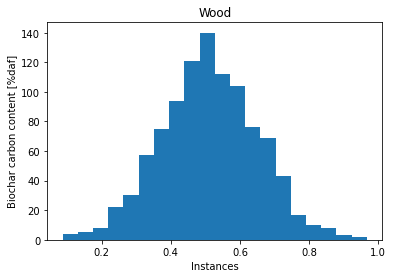

In [5]:
# Make and plot some sample distributions
wood_dist = make_dist(gaussian(mean=biochar_carbon_df["wood"]["mean"], std=biochar_carbon_df["wood"]["std"]),
                      length_array=1000)

plt.figure()
plt.title("Wood")
plt.hist(wood_dist, bins=20)
plt.xlabel("Instances")
plt.ylabel("Biochar carbon content [%daf]")
plt.show()


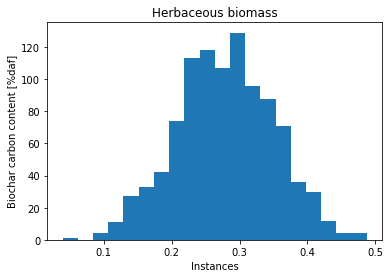

In [6]:
herbaceous_dist = make_dist(gaussian(mean=biochar_carbon_df["herbaceous biomass"]["mean"],
                               std=biochar_carbon_df["herbaceous biomass"]["std"]),
                      length_array=1000)

plt.figure()
plt.title("Herbaceous biomass")
plt.hist(herbaceous_dist, bins=20)
plt.xlabel("Instances")
plt.ylabel("Biochar carbon content [%daf]")
plt.show()

# General Biochar carbon content data


In [7]:
carbon_percentage_data_raw = np.array([60.04, 59.49, 45.7, 64.80, 1.38, 89.85, 42.0, 46.8, 65.29, 79.34, 35, 71, 33.1])
source = "10.1016/j.biortech.2017.06.177"


In [8]:
# function to reject outliers from a numpy array
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [9]:
# show data
carbon_percentage_data_raw

array([60.04, 59.49, 45.7 , 64.8 ,  1.38, 89.85, 42.  , 46.8 , 65.29,
       79.34, 35.  , 71.  , 33.1 ])

In [10]:
# Remove outliers from array and show new array
carbon_percentage_data = reject_outliers(carbon_percentage_data_raw, m=2)
carbon_percentage_data

array([60.04, 59.49, 45.7 , 64.8 , 89.85, 42.  , 46.8 , 65.29, 79.34,
       35.  , 71.  , 33.1 ])

In [11]:
mean_carbon_percentage_general = np.mean(carbon_percentage_data) / 100
std_carbon_percentage_general = np.std(carbon_percentage_data) / 100
print("Mean:", mean_carbon_percentage_general)
print("Std:", std_carbon_percentage_general)


Mean: 0.5770083333333335
Std: 0.16894895411698235


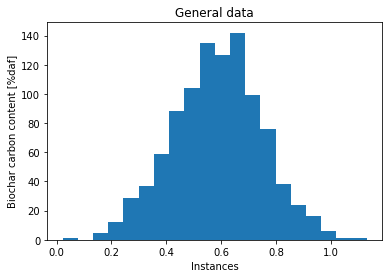

In [12]:
general_dist = make_dist(gaussian(mean=mean_carbon_percentage_general, std=std_carbon_percentage_general),
                            length_array=1000)

plt.figure()
plt.title("General data")
plt.hist(general_dist, bins=20)
plt.xlabel("Instances")
plt.ylabel("Biochar carbon content [%daf]")
plt.show()

# Recalcitrant carbon fraction

In [13]:
recalcitrant_carbon_triangular = triangular(lower=0.80,mode=0.90, upper=0.97)
recalcitrant_carbon_triangular.lower

0.8

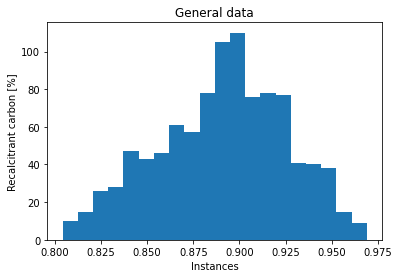

In [14]:
recalcitrant_carbon_dist = make_dist(values=recalcitrant_carbon_triangular, length_array=1000)

plt.figure()
plt.title("General data")
plt.hist(recalcitrant_carbon_dist, bins=20)
plt.xlabel("Instances")
plt.ylabel("Recalcitrant carbon [%]")
plt.show()

# Prepare outputs

In [15]:
# Add general data to dataframe
biochar_carbon_df["general"] = np.nan
biochar_carbon_df["general"]["mean"] = mean_carbon_percentage_general
biochar_carbon_df["general"]["std"] = std_carbon_percentage_general

biochar_carbon_df


,animal manure,wood,herbaceous biomass,rice husk and rice straw,"nut shells, pits, and stones","biosolids (paper sludge, sewage sludge)",general
mean,0.090000,0.520000,0.280000,0.130000,0.400000,0.070000,0.577008
95%,0.530000,0.520000,0.500000,0.500000,0.520000,0.500000,NaN
lower,0.042300,0.249600,0.140000,0.065000,0.192000,0.035000,NaN
upper,0.137700,0.790400,0.420000,0.195000,0.608000,0.105000,NaN
std,0.024337,0.137959,0.071429,0.033163,0.106122,0.017857,0.168949


# Note:
- General data has higher carbon percentage than all other more specific IPCC data.
- Some feedstock types result in very low carbon contents in biochar - likely due to high ash contents among other factors.
- IPCC data might be overly conservative whilst other data might be optimistic (if high biochar carbon content is deemed desirable).
- In practice, have model who selects based on feedstock type and reverts to general data if unknown feedstock type.


In [16]:
output_dict = {"Biochar carbon fraction": biochar_carbon_df,
               "Biochar recalcitrant carbon fraction": recalcitrant_carbon_triangular}

# Store results
with open(r"results\biochar_properties_results", "wb") as f:
    pickle.dump(output_dict, f)

# Also save to data folder
with open(r"C:\Users\2270577A\PycharmProjects\PhD_LCA_TEA\data\biochar_properties_results", "wb") as f:
    pickle.dump(output_dict, f)
